# MeLi Data Challenge 2021
O objetivo deste desafio é prever quantos dias (de 1 a 30) uma certa quantidade de uma unidade de estoque (sku) irá levar para se esgotar. Para isso temos os dados de treinamento (train_data.parquet) e os dados dos itens (items_static_metadata_full.jl).
Neste notebook iremos realizar primeiramente uma análise exploratória sobre os dados fornecidos e então, utilizaremos um modelo de aprendizado de máquina para classificação em 30 classes de cada par (sku, dias) do conjunto de teste (test_data.csv).

## Leitura dos dados
Os dados de treino estão em um arquivo do tipo `parquet` e tendem a utilizar bastante memória durante a leitura, além de ser um conjundo grande. Portanto, após a leitura utilizaremos algumas técnicas para reduzir a quantidade de memória utilizada pelos `DataFrames`.
Temos disponível também um arquivo com as informações dos itens. Após a leitura deste iremos unir as informações dos dois arquivos em um único `DataFrame` para tratamento.

In [1]:
import pandas as pd
from unidecode import unidecode

In [2]:
train_data = pd.read_parquet('data/train_data.parquet')
train_data.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0


Após a leitura, normalmente observamos um elevado uso de RAM, vamos analisar este uso no DataFrame lido e otimizá-lo seguindo o [guia para datasets grandes](https://pandas.pydata.org/docs/user_guide/scale.html).

In [3]:
train_data.dtypes

sku                         int64
date                       object
sold_quantity               int64
current_price             float64
currency                   object
listing_type               object
shipping_logistic_type     object
shipping_payment           object
minutes_active            float64
dtype: object

In [4]:
train_data.memory_usage(deep=True)

Index                            128
sku                        301282232
date                      2523238693
sold_quantity              301282232
current_price              301282232
currency                  2259616740
listing_type              2410257856
shipping_logistic_type    2557613835
shipping_payment          2636219530
minutes_active             301282232
dtype: int64

In [5]:
mem_before = train_data.memory_usage(deep=True).sum()
mem_before

13592075710

In [6]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['currency'] = train_data['currency'].astype('category')
train_data['listing_type'] = train_data['listing_type'].astype('category')
train_data['shipping_logistic_type'] = train_data['shipping_logistic_type'].astype('category')
train_data['shipping_payment'] = train_data['shipping_payment'].astype('category')

In [7]:
train_data.dtypes

sku                                int64
date                      datetime64[ns]
sold_quantity                      int64
current_price                    float64
currency                        category
listing_type                    category
shipping_logistic_type          category
shipping_payment                category
minutes_active                   float64
dtype: object

In [8]:
train_data.memory_usage(deep=True)

Index                           128
sku                       301282232
date                      301282232
sold_quantity             301282232
current_price             301282232
currency                   37660691
listing_type               37660515
shipping_logistic_type     37660590
shipping_payment           37660527
minutes_active            301282232
dtype: int64

In [9]:
mem_after = train_data.memory_usage(deep=True).sum()
mem_after / mem_before

0.12191321225358301

Após a redução para 12% do tamanho original, vamos ler o segundo arquivo de dados e aplicar algumas das mesmas transformações, para então juntá-los em um único `DataFrame` para melhor análise.

In [10]:
items_data = pd.read_json('data/items_static_metadata_full.jl', lines=True)
items_data

,item_domain_id,item_id,item_title,site_id,sku,product_id,product_family_id
0,MLB-SNEAKERS,492155,Tênis Masculino Olympikus Cyber Barato Promoçao,MLB,0,None,MLB15832732
1,MLB-SURFBOARD_RACKS,300279,Suporte Rack Prancha Parede C/ Regulagem Horiz...,MLB,1,None,None
2,MLM-NECKLACES,69847,5 Collares Plateados Dama Gargantilla Choker -...,MLM,2,None,None
3,MLM-RINGS,298603,Lindo Anillo De Bella Crepusculo Twilight Prom...,MLM,3,None,None
4,MLB-WEBCAMS,345949,Webcam Com Microfone Hd 720p Knup Youtube Pc V...,MLB,4,None,None
...,...,...,...,...,...,...,...
660911,MLB-CELLPHONE_PARTS,320792,2 Parafuso Pentalobe Torx iPhone 5 5c 5s 6 6s ...,MLB,660911,None,None
660912,MLM-AUTOMOTIVE_EMBLEMS,90441,Emblema Circular Wolfsburg Edition 5cm,MLM,660912,None,None
660913,MLB-SOFA_AND_FUTON_COVERS,202580,Kit Capa De Sofá Coladinha Jogo 2e3 Lugares Ma...,MLB,660913,None,None
660914,MLB-SNEAKERS,490874,Calçado Sapatênis Clássico Baltic 234 Ollie,MLB,660914,None,None


In [11]:
items_data.dtypes

item_domain_id       object
item_id               int64
item_title           object
site_id              object
sku                   int64
product_id           object
product_family_id    object
dtype: object

In [12]:
items_data['item_domain_id'] = items_data['item_domain_id'].astype('category')
items_data['item_title'] = items_data['item_title'].apply(unidecode).astype('category')
items_data['site_id'] = items_data['site_id'].astype('category')
items_data['product_id'] = items_data['product_id'].astype('category')
items_data['product_family_id'] = items_data['product_family_id'].astype('category')

In [13]:
df = train_data.merge(items_data, how='left', on='sku')
df.shape

(37660279, 15)

## Análise Exploratória - Primeira Fase
Agora que temos os dados carregados em memória e tratados para menor consumo de RAM, vamos iniciar a análise exploratória.
Neste _notebook_ faremos a análise de cada variável de forma independente (ou com relação apenas ao tempo) e depois aprofundaremos as análises para relações entre duas ou mais variáveis.
Esta análise terá por objetivo entender o preenchimento dos dados e tirar insights para ajudar na futura modelagem do problema.

In [14]:
df.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,item_domain_id,item_id,item_title,site_id,product_id,product_family_id
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510


In [15]:
df.dtypes

sku                                int64
date                      datetime64[ns]
sold_quantity                      int64
current_price                    float64
currency                        category
listing_type                    category
shipping_logistic_type          category
shipping_payment                category
minutes_active                   float64
item_domain_id                  category
item_id                            int64
item_title                      category
site_id                         category
product_id                      category
product_family_id               category
dtype: object

### SKU - `int64`
É uma coluna de id, vamos apenas validar que segue todas as propriedades

In [16]:
print('count:', df['sku'].count())
print('NAs:', df['sku'].isna().sum())
print('min:', df['sku'].min())
print('max:', df['sku'].max())
print('uniques:', df['sku'].nunique())

count: 37660279
NAs: 0
min: 0
max: 660915
uniques: 660916


### Date - `datetime64[ns]`

Coluna de data, aqui temos os dois meses usados para treino: Fevereiro e Março

In [17]:
df['date'].isna().sum()

0

Temos mais registros referentes ao mês de Março

<AxesSubplot:>

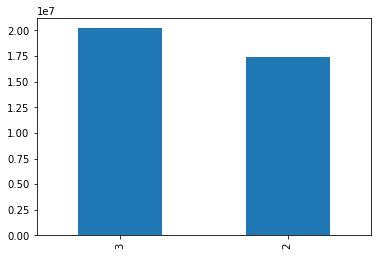

In [18]:
df['date'].dt.month.value_counts().plot.bar()

Vemos uma queda brusca na quantidade de registros nos dias 29, 30 e 31, isso se dá por conta de um dos meses ser Fevereiro, o qual possui apenas 28 dias.
Olhando para os dias 1-28, vemos algo que parece uma tendência de subida na quantidade de registros. O que isto quer dizer?

<AxesSubplot:>

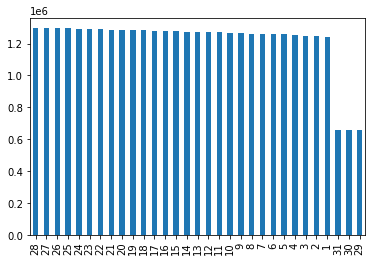

In [19]:
df['date'].dt.day.value_counts().plot.bar()

Vamos comparar a quantidade de registros entre os meses desconsiderando os dias 29, 30 e 31 de março. Ainda temos mais registros para Março.

<AxesSubplot:>

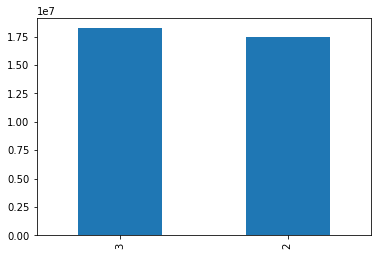

In [25]:
filter_last_days = df['date'].dt.day < 29
df[filter_last_days]['date'].dt.month.value_counts().plot.bar()

Olhando para cada semana do ano, a leve tendência de mais registros conforme o tempo passa continua.

<ipython-input-31-59ca919a3701>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[filter_last_days]['date'].dt.week.value_counts().plot.bar()


<AxesSubplot:>

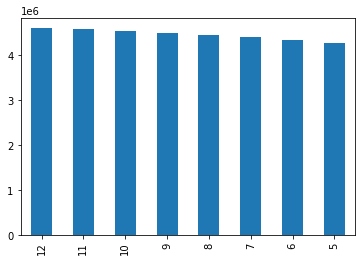

In [31]:
df[filter_last_days]['date'].dt.week.value_counts().plot.bar()

A distribuição de datas ao longo da semana é uniforme. Não apresenta mais registros em certos dias da semana.

<AxesSubplot:>

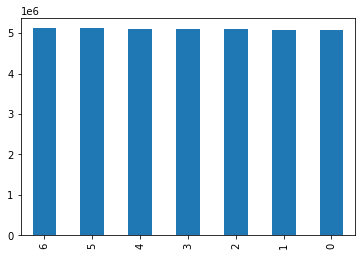

In [43]:
df[filter_last_days]['date'].dt.weekday.value_counts().plot.bar()

### Sold Quantity - `int64`

Quantidade de unidades vendidas no dia de referência

### Current Price - `float64`

Preço do anúncio no dia de referência

### Currency - `category`

Em qual moeda está o preço do anúncio

### Listing Type - `category`

Qual o tipo do anúncio

### Shipping Logistic Type - `category`

Tipo do frete

### Shipping Payment - `category`
Comprador paga pelo frete?

### Minutes Active - `float64`
Quantos minutos o anúncio ficou ativo no dia

### Item Domain ID - `category`
A qual domínio este item pertence

### Item ID - `int64`
Identificador do item

### Item Title - `category`
Texto do título do anúncio

### Site ID - `category`
Em qual MercadoLivre está anunciado?

### Product ID - `category` 
Qual é este produto

### Product Family ID - `category`
A qual família este produto pertence